https://www.cs.toronto.edu/~kriz/cifar.html

In [1]:
import my_utils as utl
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV
from time import time

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
y_train, y_test = tf.keras.utils.to_categorical(y_train, 10), tf.keras.utils.to_categorical(y_test, 10)
x_train, x_test = x_train/255 , x_test/255
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.15, shuffle=True)

In [ ]:
# show image
#img = Image.fromarray(x_train[1], 'RGB')
#img.show()
# transform to gray np.dot(x_train[1], [0.2989, 0.5870, 0.1140])

plt.imshow(x_train[0], cmap='gray')
plt.show()

In [3]:
print(28*28)
print(x_train.shape)
y_train.shape

784
(51000, 28, 28)


(51000, 10)

In [47]:
model = tf.keras.models.Sequential(
    [
        tf.keras.layers.Flatten(input_shape=(28,28)),
        #tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(150, name="layer1"), #kernel_initializer="he_normal"
        tf.keras.layers.Activation(tf.keras.activations.relu),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(10, activation="softmax", name="output_layer"),
    ]
)
model.compile(optimizer = 'adam', loss="categorical_crossentropy", metrics=["accuracy"])
EarlyStopping_callback = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
#ModelCheckpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath="checkpoint", save_best_only=True)
#TensorBoard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs")
model_history = model.fit(x=x_train, y=y_train, epochs=200, batch_size=32, validation_data=(x_val, y_val), callbacks=[EarlyStopping_callback])

Epoch 1/200
1594/1594 [==============================] - 2s 1ms/step - loss: 0.6634 - accuracy: 0.7625 - val_loss: 0.4565 - val_accuracy: 0.8346
Epoch 2/200
1594/1594 [==============================] - 2s 1ms/step - loss: 0.5113 - accuracy: 0.8158 - val_loss: 0.4052 - val_accuracy: 0.8480
Epoch 3/200
1594/1594 [==============================] - 2s 1ms/step - loss: 0.4739 - accuracy: 0.8284 - val_loss: 0.3912 - val_accuracy: 0.8594
Epoch 4/200
1594/1594 [==============================] - 2s 1ms/step - loss: 0.4533 - accuracy: 0.8378 - val_loss: 0.3733 - val_accuracy: 0.8569
Epoch 5/200
1594/1594 [==============================] - 2s 1ms/step - loss: 0.4322 - accuracy: 0.8435 - val_loss: 0.3570 - val_accuracy: 0.8673
Epoch 6/200
1594/1594 [==============================] - 2s 1ms/step - loss: 0.4183 - accuracy: 0.8485 - val_loss: 0.3513 - val_accuracy: 0.8703
Epoch 7/200
1594/1594 [==============================] - 2s 1ms/step - loss: 0.4058 - accuracy: 0.8515 - val_loss: 0.3497 - val_ac

In [ ]:
def create_model(layer_num = 1, neoron_num = 50, optimizer = 'sgd'):

    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Flatten(input_shape=(28,28)))
    for i in range(layer_num):
        model.add(tf.keras.layers.Dense(neoron_num, activation="relu", name="layer"+str(i)))
    model.add(tf.keras.layers.Dense(10, activation="softmax", name="output_layer"))
    model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

    return model

start=time()
model = KerasClassifier(model=create_model, layer_num = None, neoron_num = None, optimizer = None, verbose=1)
param_grid = {
    "layer_num" : [1, 2, 3, 4, 5],
    "neoron_num" : [50, 100, 200],
    "optimizer" : ['sgd', 'rmsprop', 'adam']
    #"batch_size" : [10, 20, 30],
    #"init" : ['glorot_uniform', 'normal', 'uniform']
}

grid = RandomizedSearchCV(estimator=model, param_distributions=param_grid, verbose=1, )
grid_result = grid.fit(x_train, y_train, epochs=100, validation_data=(x_val, y_val), callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)])

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
for mean, stdev, param, mean_fit_time in zip(grid_result.cv_results_['mean_test_score'], grid_result.cv_results_['std_test_score'], grid_result.cv_results_['params'], grid_result.cv_results_['mean_fit_time']):
    print("%f (%f) , time: %d  with: %r" % (mean, stdev, mean_fit_time/60, param))
print("total time:",time()-start)

In [ ]:
# tensorboard
%load_ext tensorboard
%tensorboard --logdir=./logs #--port=8877

In [48]:
model.evaluate(x=x_test, y=y_test, verbose=1)

313/313 [==============================] - 0s 681us/step - loss: 0.3401 - accuracy: 0.8800


[0.3401317000389099, 0.8799999952316284]

In [20]:
pred = model.predict(x_test)

313/313 [==============================] - 0s 623us/step


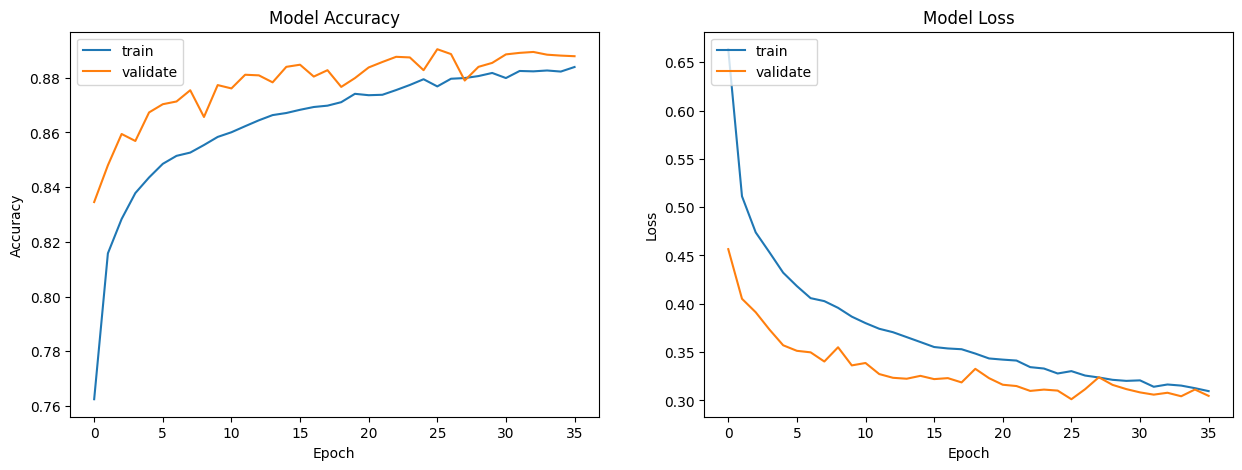

In [49]:
utl.plot_model_history(model_history)

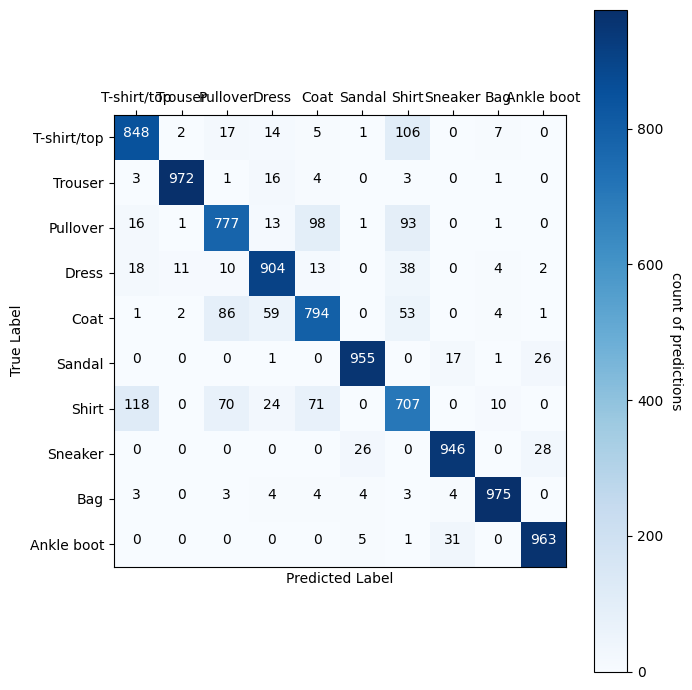

In [7]:
labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
Y_pred_classes = np.argmax(pred, axis=1) 
Y_true = np.argmax(y_test, axis=1) 
errors = (Y_pred_classes - Y_true != 0)
Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = pred[errors]
Y_true_errors = Y_true[errors]
X_test_errors = x_test[errors]

cm = confusion_matrix(Y_true, Y_pred_classes) 
thresh = cm.max() / 2.

fig, ax = plt.subplots(figsize=(7,7))
im, cbar = utl.heatmap(cm, labels, labels, ax=ax,cmap=plt.cm.Blues, cbarlabel="count of predictions")
texts = utl.annotate_heatmap(im, data=cm, threshold=thresh)

fig.tight_layout()
plt.show()

In [8]:
print(classification_report(Y_true, Y_pred_classes))

              precision    recall  f1-score   support

           0       0.84      0.85      0.85      1000
           1       0.98      0.97      0.98      1000
           2       0.81      0.78      0.79      1000
           3       0.87      0.90      0.89      1000
           4       0.80      0.79      0.80      1000
           5       0.96      0.95      0.96      1000
           6       0.70      0.71      0.71      1000
           7       0.95      0.95      0.95      1000
           8       0.97      0.97      0.97      1000
           9       0.94      0.96      0.95      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



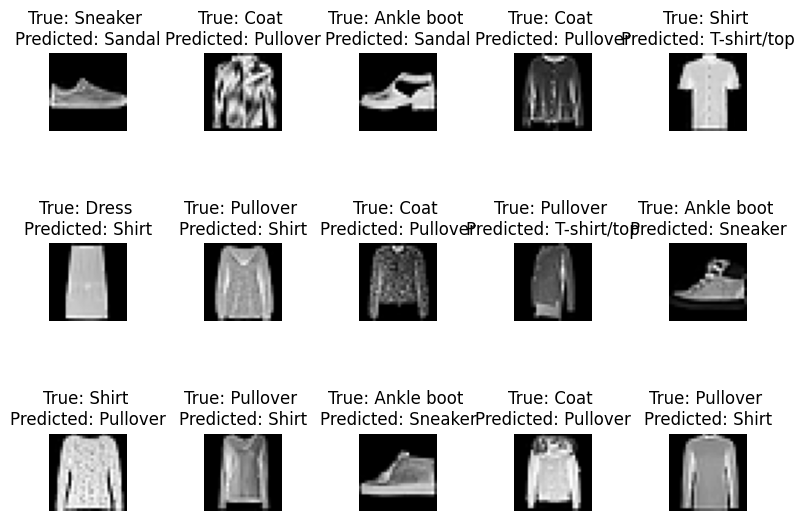

In [9]:
utl.error_imshow(Y_true, Y_pred_classes, x_test, labels)

In [10]:
model.save("fashion_mnist.h5")
#tf.keras.models.load_model("fashion_mnist.h5")